# Регуляризация

В рамках задания предлагается улучшить качество модели, подверженной переобучению.

Загрузим корпус MNIST и оставим 10000 тренировочных примеров.

USE CUDA: True


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Train size: 1000
Test size: 10000


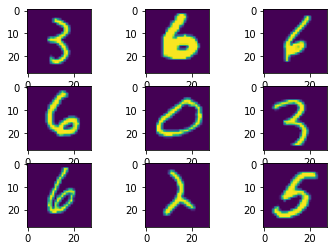

In [ ]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from tqdm import tqdm

USE_CUDA = torch.cuda.is_available()
print("USE CUDA:", USE_CUDA)

torch.manual_seed(0)
np.random.seed(0)

SUBSET_SIZE = 1000
BATCH_SIZE = 32

transform = torchvision.transforms.ToTensor()

train = MNIST("mnist", train=True, transform=transform, download=True)
train = torch.utils.data.Subset(train, np.random.permutation(len(train))[:SUBSET_SIZE])
test = MNIST("mnist", train=False, transform=transform, download=True)
print("Train size:", len(train))
print("Test size:", len(test))

def draw(dataset):
    images, labels = zip(*[dataset[i] for i in range(9)])
    fig, axs = plt.subplots(3, 3, squeeze=False)
    for i, image in enumerate(images):
        ax = axs[i // 3, i % 3]
        ax.imshow(image.permute(1, 2, 0).squeeze(-1))
    plt.show()

draw(train)

In [ ]:
def compute_accuracy(model, loader):
    if USE_CUDA:
        model.cuda()
    model.eval()
    n_correct = 0
    n = 0
    for images, labels in loader:
        if USE_CUDA:
            images = images.cuda()
            labels = labels.cuda()
        n_correct += (model(images).argmax(dim=1) == labels).sum().item()
        n += len(images)
    return n_correct / n

Num parameters 3226
Epoch 0, loss 2.288, train 0.341, test 0.319
Epoch 1, loss 2.101, train 0.598, test 0.574
Epoch 2, loss 1.153, train 0.810, test 0.778
Epoch 3, loss 0.622, train 0.873, test 0.847
Epoch 4, loss 0.448, train 0.895, test 0.847
Epoch 5, loss 0.374, train 0.901, test 0.850
Epoch 6, loss 0.324, train 0.912, test 0.854
Epoch 7, loss 0.284, train 0.922, test 0.861
Epoch 8, loss 0.251, train 0.926, test 0.867
Epoch 9, loss 0.224, train 0.941, test 0.870
Epoch 10, loss 0.200, train 0.945, test 0.873
Epoch 11, loss 0.178, train 0.949, test 0.878
Epoch 12, loss 0.159, train 0.955, test 0.879
Epoch 13, loss 0.142, train 0.959, test 0.881
Epoch 14, loss 0.126, train 0.959, test 0.884
Epoch 15, loss 0.113, train 0.961, test 0.885
Epoch 16, loss 0.101, train 0.961, test 0.886
Epoch 17, loss 0.091, train 0.967, test 0.887
Epoch 18, loss 0.080, train 0.968, test 0.888
Epoch 19, loss 0.070, train 0.966, test 0.888
Weights norm 7.146504878997803


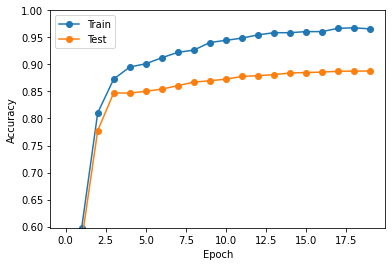

In [ ]:
def run(model, **optimizer_kwargs):
    print("Num parameters", sum(map(torch.numel, model.parameters())))
    if USE_CUDA:
        model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=optimizer_kwargs.get("lr", 0.1),
                                **optimizer_kwargs)
    loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, drop_last=True)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)
    train_accuracies = []
    test_accuracies = []
    for epoch in range(20):
        model.train()
        losses = []
        for images, labels in loader:
            if USE_CUDA:
                images = images.cuda()
                labels = labels.cuda()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        model.eval()
        train_accuracy = compute_accuracy(model, loader)
        test_accuracy = compute_accuracy(model, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch}, loss {np.mean(losses):.3f}, train {train_accuracy:.3f}, test {test_accuracy:.3f}")
    print("Weights norm", torch.linalg.norm(torch.concat([p.flatten() for p in model.parameters()])).item())
    plt.ylim(train_accuracies[1], 1)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(train_accuracies, label="Train", marker="o")
    plt.plot(test_accuracies, label="Test", marker="o")
    plt.legend()
    plt.show()
    
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)
        
run(model)

Num parameters 3226
Epoch 0, loss 2.292, train 0.321, test 0.294
Epoch 1, loss 2.232, train 0.502, test 0.464
Epoch 2, loss 1.644, train 0.728, test 0.681
Epoch 3, loss 0.864, train 0.845, test 0.820
Epoch 4, loss 0.596, train 0.877, test 0.844
Epoch 5, loss 0.507, train 0.887, test 0.854
Epoch 6, loss 0.462, train 0.899, test 0.857
Epoch 7, loss 0.431, train 0.904, test 0.859
Epoch 8, loss 0.411, train 0.909, test 0.861
Epoch 9, loss 0.394, train 0.915, test 0.863
Epoch 10, loss 0.381, train 0.919, test 0.865
Epoch 11, loss 0.370, train 0.919, test 0.867
Epoch 12, loss 0.362, train 0.921, test 0.867
Epoch 13, loss 0.355, train 0.920, test 0.868
Epoch 14, loss 0.348, train 0.921, test 0.869
Epoch 15, loss 0.343, train 0.924, test 0.870
Epoch 16, loss 0.338, train 0.924, test 0.870
Epoch 17, loss 0.334, train 0.922, test 0.871
Epoch 18, loss 0.330, train 0.925, test 0.872
Epoch 19, loss 0.327, train 0.928, test 0.873
Weights norm 3.935408592224121


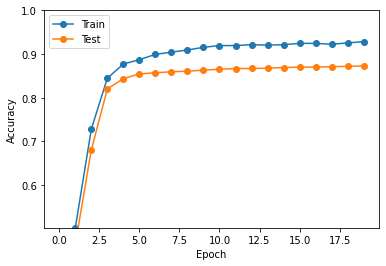

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)

run(model, weight_decay=0.05)

При `weight_decay=0.05` точность на train падает на 4.3%, а на test на 1.4%. Таким образом переобучение становится меньше, но качество на test падает.

**Задание 1**. Может ли выбор `weight_decay` увеличить точность на train? Какой максимальной точности на test можно добиться подбором этого параметра? Может ли точность на train и test примерно сравняться?

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)

#run(model, weight_decay=...)  # Ваш параметр.

In [ ]:
wd = [1e-5, 1e-4, 0.001, 0.01, 0.1]

Num parameters 3226
Epoch 0, loss 2.288, train 0.341, test 0.319
Epoch 1, loss 2.101, train 0.599, test 0.574
Epoch 2, loss 1.153, train 0.809, test 0.778
Epoch 3, loss 0.622, train 0.872, test 0.848
Epoch 4, loss 0.448, train 0.895, test 0.847
Epoch 5, loss 0.374, train 0.900, test 0.851
Epoch 6, loss 0.324, train 0.913, test 0.854
Epoch 7, loss 0.284, train 0.922, test 0.861
Epoch 8, loss 0.251, train 0.927, test 0.867
Epoch 9, loss 0.224, train 0.940, test 0.870
Epoch 10, loss 0.200, train 0.945, test 0.872
Epoch 11, loss 0.179, train 0.949, test 0.877
Epoch 12, loss 0.159, train 0.955, test 0.879
Epoch 13, loss 0.142, train 0.958, test 0.881
Epoch 14, loss 0.127, train 0.958, test 0.885
Epoch 15, loss 0.113, train 0.961, test 0.885
Epoch 16, loss 0.101, train 0.962, test 0.886
Epoch 17, loss 0.090, train 0.965, test 0.887
Epoch 18, loss 0.081, train 0.969, test 0.887
Epoch 19, loss 0.072, train 0.964, test 0.883
Weights norm 7.143161773681641


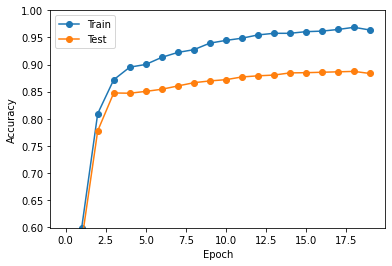

Num parameters 3226
Epoch 0, loss 0.067, train 0.979, test 0.888
Epoch 1, loss 0.181, train 0.972, test 0.887
Epoch 2, loss 0.065, train 0.981, test 0.884
Epoch 3, loss 0.046, train 0.985, test 0.890
Epoch 4, loss 0.033, train 0.988, test 0.893
Epoch 5, loss 0.045, train 0.988, test 0.893
Epoch 6, loss 0.032, train 0.992, test 0.895
Epoch 7, loss 0.019, train 0.997, test 0.896
Epoch 8, loss 0.015, train 0.997, test 0.897
Epoch 9, loss 0.013, train 0.997, test 0.897
Epoch 10, loss 0.011, train 0.998, test 0.898
Epoch 11, loss 0.010, train 0.998, test 0.898
Epoch 12, loss 0.009, train 0.998, test 0.898
Epoch 13, loss 0.008, train 0.998, test 0.898
Epoch 14, loss 0.007, train 0.999, test 0.899
Epoch 15, loss 0.007, train 0.999, test 0.900
Epoch 16, loss 0.006, train 0.999, test 0.900
Epoch 17, loss 0.006, train 0.999, test 0.900
Epoch 18, loss 0.005, train 0.999, test 0.900
Epoch 19, loss 0.005, train 0.999, test 0.901
Weights norm 8.085878372192383


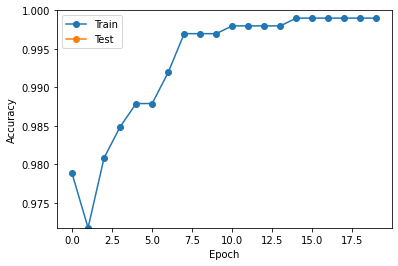

Num parameters 3226
Epoch 0, loss 0.005, train 0.999, test 0.900
Epoch 1, loss 0.005, train 0.999, test 0.900
Epoch 2, loss 0.005, train 0.999, test 0.900
Epoch 3, loss 0.004, train 0.999, test 0.901
Epoch 4, loss 0.004, train 0.999, test 0.900
Epoch 5, loss 0.004, train 1.000, test 0.901
Epoch 6, loss 0.004, train 1.000, test 0.901
Epoch 7, loss 0.004, train 1.000, test 0.901
Epoch 8, loss 0.004, train 1.000, test 0.901
Epoch 9, loss 0.004, train 1.000, test 0.901
Epoch 10, loss 0.004, train 1.000, test 0.901
Epoch 11, loss 0.004, train 1.000, test 0.900
Epoch 12, loss 0.004, train 1.000, test 0.900
Epoch 13, loss 0.004, train 1.000, test 0.900
Epoch 14, loss 0.004, train 1.000, test 0.900
Epoch 15, loss 0.003, train 1.000, test 0.900
Epoch 16, loss 0.003, train 1.000, test 0.900
Epoch 17, loss 0.003, train 1.000, test 0.900
Epoch 18, loss 0.003, train 1.000, test 0.901
Epoch 19, loss 0.003, train 1.000, test 0.901
Weights norm 7.9591593742370605


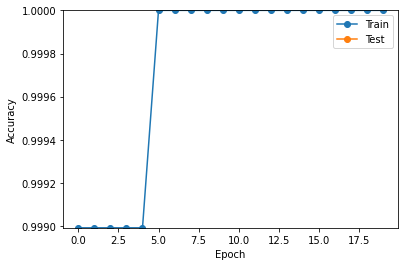

Num parameters 3226
Epoch 0, loss 0.004, train 1.000, test 0.901
Epoch 1, loss 0.006, train 1.000, test 0.901
Epoch 2, loss 0.007, train 1.000, test 0.901
Epoch 3, loss 0.010, train 1.000, test 0.901
Epoch 4, loss 0.013, train 1.000, test 0.900
Epoch 5, loss 0.016, train 1.000, test 0.899
Epoch 6, loss 0.020, train 1.000, test 0.899
Epoch 7, loss 0.024, train 1.000, test 0.900
Epoch 8, loss 0.029, train 0.998, test 0.900
Epoch 9, loss 0.033, train 0.997, test 0.898
Epoch 10, loss 0.037, train 0.991, test 0.896
Epoch 11, loss 0.040, train 0.984, test 0.893
Epoch 12, loss 0.042, train 0.995, test 0.901
Epoch 13, loss 0.337, train 0.976, test 0.892
Epoch 14, loss 0.074, train 0.992, test 0.904
Epoch 15, loss 0.050, train 0.994, test 0.905
Epoch 16, loss 0.045, train 0.995, test 0.906
Epoch 17, loss 0.044, train 0.995, test 0.906
Epoch 18, loss 0.044, train 0.995, test 0.907
Epoch 19, loss 0.044, train 0.995, test 0.907
Weights norm 6.030577182769775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.


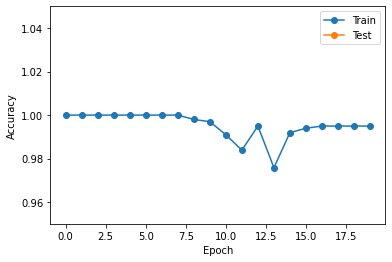

Num parameters 3226
Epoch 0, loss 0.161, train 0.967, test 0.890
Epoch 1, loss 0.291, train 0.948, test 0.884
Epoch 2, loss 0.377, train 0.931, test 0.879
Epoch 3, loss 0.419, train 0.921, test 0.875
Epoch 4, loss 0.443, train 0.918, test 0.871
Epoch 5, loss 0.458, train 0.915, test 0.869
Epoch 6, loss 0.468, train 0.911, test 0.867
Epoch 7, loss 0.475, train 0.910, test 0.865
Epoch 8, loss 0.479, train 0.908, test 0.864
Epoch 9, loss 0.482, train 0.905, test 0.863
Epoch 10, loss 0.485, train 0.904, test 0.862
Epoch 11, loss 0.486, train 0.904, test 0.860
Epoch 12, loss 0.488, train 0.903, test 0.860
Epoch 13, loss 0.488, train 0.903, test 0.859
Epoch 14, loss 0.489, train 0.903, test 0.858
Epoch 15, loss 0.489, train 0.904, test 0.857
Epoch 16, loss 0.490, train 0.903, test 0.857
Epoch 17, loss 0.491, train 0.903, test 0.857
Epoch 18, loss 0.491, train 0.902, test 0.856
Epoch 19, loss 0.492, train 0.902, test 0.855
Weights norm 3.3127083778381348


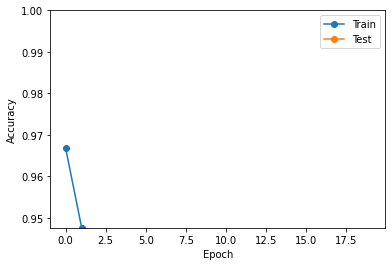

In [ ]:
for i in wd:
  run(model, weight_decay=i)

**Задание 2.** Добавьте `torch.nn.Dropout`, подберите параметр и увеличьте точность на test до 90% или выше. Изменилось ли число параметров модели? Вырастает ли при этом точность на train?

Num parameters 3226
Epoch 0, loss 2.284, train 0.371, test 0.340
Epoch 1, loss 2.129, train 0.592, test 0.561
Epoch 2, loss 1.331, train 0.825, test 0.787
Epoch 3, loss 0.879, train 0.861, test 0.829
Epoch 4, loss 0.677, train 0.874, test 0.836
Epoch 5, loss 0.619, train 0.902, test 0.861
Epoch 6, loss 0.552, train 0.913, test 0.867
Epoch 7, loss 0.520, train 0.892, test 0.853
Epoch 8, loss 0.467, train 0.907, test 0.863
Epoch 9, loss 0.431, train 0.929, test 0.883
Epoch 10, loss 0.436, train 0.923, test 0.876
Epoch 11, loss 0.450, train 0.940, test 0.894
Epoch 12, loss 0.387, train 0.948, test 0.889
Epoch 13, loss 0.379, train 0.949, test 0.891
Epoch 14, loss 0.369, train 0.948, test 0.892
Epoch 15, loss 0.362, train 0.956, test 0.897
Epoch 16, loss 0.345, train 0.956, test 0.895
Epoch 17, loss 0.358, train 0.957, test 0.901
Epoch 18, loss 0.316, train 0.956, test 0.885
Epoch 19, loss 0.348, train 0.958, test 0.895
Weights norm 7.019128322601318


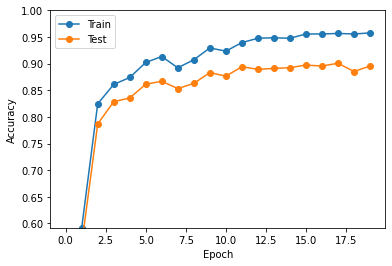

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(288, 10)
)  # Добавьте dropout в модель.

run(model)

**Задание 3** Добавить BatchNorm2d в модель. Изменилось ли при этом число параметров модели? Увеличьте точность на test до 89% или выше. Насколько можно увеличить точность на train?

Num parameters 3250
Epoch 0, loss 1.291, train 0.830, test 0.787
Epoch 1, loss 0.535, train 0.892, test 0.843
Epoch 2, loss 0.376, train 0.918, test 0.863
Epoch 3, loss 0.287, train 0.941, test 0.870
Epoch 4, loss 0.223, train 0.955, test 0.873
Epoch 5, loss 0.175, train 0.965, test 0.875
Epoch 6, loss 0.139, train 0.977, test 0.880
Epoch 7, loss 0.109, train 0.984, test 0.881
Epoch 8, loss 0.088, train 0.988, test 0.883
Epoch 9, loss 0.070, train 0.994, test 0.884
Epoch 10, loss 0.057, train 0.997, test 0.886
Epoch 11, loss 0.047, train 0.997, test 0.886
Epoch 12, loss 0.039, train 0.999, test 0.888
Epoch 13, loss 0.033, train 1.000, test 0.888
Epoch 14, loss 0.029, train 1.000, test 0.888
Epoch 15, loss 0.025, train 1.000, test 0.889
Epoch 16, loss 0.023, train 1.000, test 0.889
Epoch 17, loss 0.020, train 1.000, test 0.889
Epoch 18, loss 0.018, train 1.000, test 0.889
Epoch 19, loss 0.017, train 1.000, test 0.889
Weights norm 7.8611860275268555


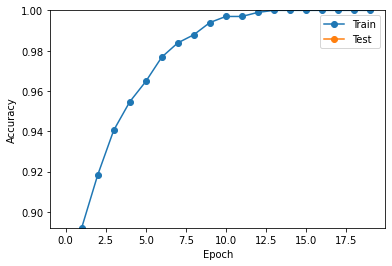

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.BatchNorm2d(4),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.BatchNorm2d(8),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)  # Добавьте BatchNorm2d в модель (возможно несколько раз).

run(model)

**Задание 4.** Попробуйте добиться точности 92% или выше на test используя все предыдущие способы (можно добиться 93%+).

Num parameters 3250
Epoch 0, loss 1.568, train 0.787, test 0.738
Epoch 1, loss 1.005, train 0.861, test 0.834
Epoch 2, loss 0.831, train 0.886, test 0.852
Epoch 3, loss 0.702, train 0.905, test 0.866
Epoch 4, loss 0.658, train 0.918, test 0.877
Epoch 5, loss 0.622, train 0.920, test 0.885
Epoch 6, loss 0.576, train 0.936, test 0.895
Epoch 7, loss 0.533, train 0.941, test 0.893
Epoch 8, loss 0.508, train 0.939, test 0.892
Epoch 9, loss 0.541, train 0.943, test 0.897
Epoch 10, loss 0.485, train 0.946, test 0.910
Epoch 11, loss 0.466, train 0.955, test 0.913
Epoch 12, loss 0.398, train 0.954, test 0.916
Epoch 13, loss 0.433, train 0.959, test 0.914
Epoch 14, loss 0.447, train 0.949, test 0.909
Epoch 15, loss 0.408, train 0.957, test 0.915
Epoch 16, loss 0.393, train 0.960, test 0.918
Epoch 17, loss 0.354, train 0.969, test 0.920
Epoch 18, loss 0.381, train 0.969, test 0.923
Epoch 19, loss 0.394, train 0.964, test 0.914
Weights norm 7.680425643920898


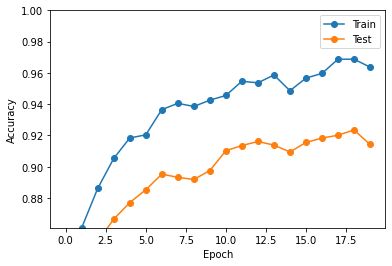

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.BatchNorm2d(4),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.BatchNorm2d(8),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.6),
    torch.nn.Linear(288, 10)
)

run(model,weight_decay=1e-3)